In [11]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from numpy import random

from scipy.stats import chi2
from scipy.special import erfcinv
from scipy.linalg import sqrtm, inv


import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def W_ij(diff_mean_i, diff_mean_j, cov_i, cov_j,n_samples,L):
    
    # Covariance matrices
    #Sigma_X = cov_i
    #Sigma_Y = cov_j 

    # Matrix A (can be arbitrary)
    A = np.dot(sqrtm(np.linalg.inv(cov_i)),sqrtm(np.linalg.inv(cov_j)))/L**2 #np.random.randn(d, d)  # Random matrix as an example

    # Sampling
    X = np.random.multivariate_normal(diff_mean_i, cov_i, size=n_samples).T  # Shape: (d, n_samples)
    Y = np.random.multivariate_normal(diff_mean_j, cov_j, size=n_samples).T  # Shape: (d, n_samples)

    # Compute W for each sample
    W = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        W[i] = np.dot(X[:, i], np.dot(A, Y[:, i]))  # Shape: (n_samples,)

    return W

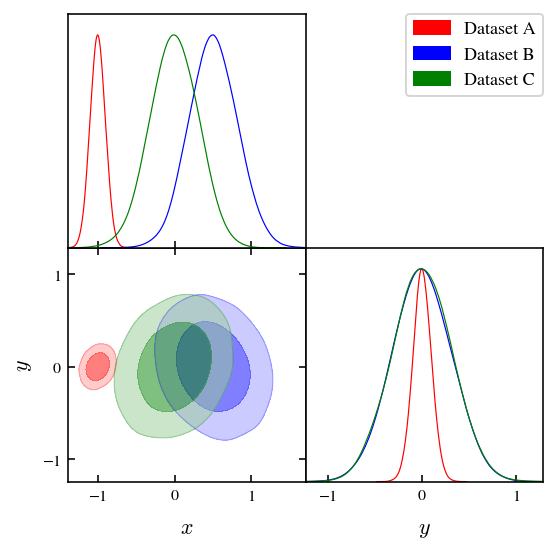

In [13]:
#Sharp triangle
num_datasets=2
num_parameters=2
df=num_datasets*num_parameters
num_samples=int(1e5)


mean_A = np.array([-1., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0., 0.])

cov_A = np.array([[1, 0.2], [0.2, 1]])/100
cov_B = np.array([[1, -0.2], [-0.2, 1]])/10
cov_C = np.array([[1, 0.2], [0.2, 1]])/10

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Parameters
d = 2  # Dimension
N = 3  # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples

In [15]:
cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples,L)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples,L)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples,L)

W_tot = np.sum((W_12, W_13, W_23), axis=0)
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot = W_tot + Q_tot
print(Q_tot)
print(W_tot)
print(R_tot)

[0.31446046 0.45661956 0.72398121 ... 0.19882042 1.08901247 0.16837828]
[ 1.48555324 -0.98833698  1.78716836 ...  0.03886546  1.02625988
 -2.33786789]
[ 1.8000137  -0.53171742  2.51114957 ...  0.23768587  2.11527235
 -2.16948961]


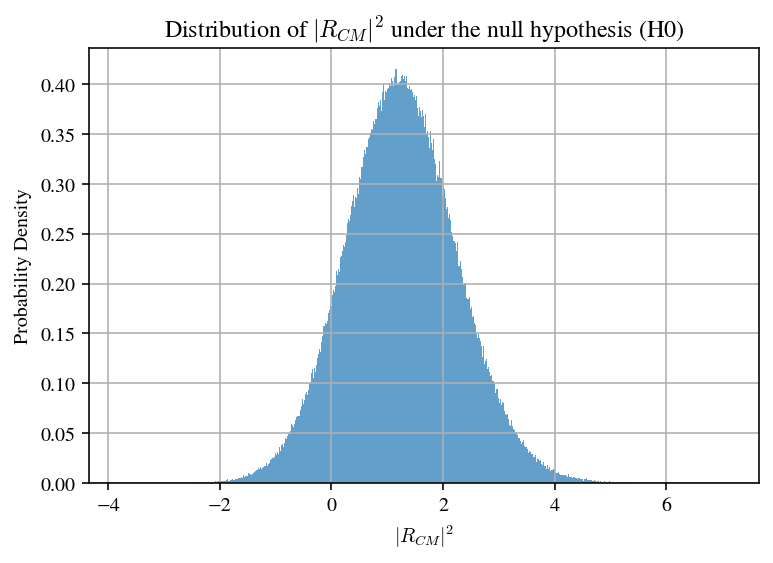

In [16]:
# Plot histogram
plt.hist(W_tot+Q_tot, bins=int(np.sqrt(len(Q_tot))), density=True, alpha=0.7)
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [17]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))


Center of mass: [-2.17088696 -0.02235603]


In [18]:
PTE = R_tot[R_tot >= np.linalg.norm(R_CM)**2].size/R_tot.size

n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')


PTE = 0.000737
n_sigma = 3.375431636408246
